In [1]:
from torchvision.datasets import CIFAR100
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image

#CIFAR
class Cifar100(CIFAR100):
    def __init__(self, root = 'Dataset', classes=range(10), train=True, transform=None, target_transform=None, download=True):
        
        super(Cifar100, self).__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)

        # Select subset of classes
        
        data = []
        targets = []

        for i in range(len(self.data)):
            if self.targets[i] in classes:
                data.append(self.data[i])
                targets.append(self.targets[i])

        self.data = np.array(data)
        self.targets = targets


    def __getitem__(self, index):
        
        img, target = self.data[index], self.targets[index]
       
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return index, img, target

    def __len__(self):
        
        return len(self.data)

    def get_image_class(self, label):
        return self.data[np.array(self.targets) == label]

    def append(self, images, labels):

        self.data = np.concatenate((self.data, images), axis=0)
        self.targets = self.targets + labels


In [6]:
#finetuning
import numpy as np

import torch

import torch.nn as nn
import torch.optim as optim

import numpy as np

from torchvision import transforms
from torch.utils.data import DataLoader
import copy
from resnet_cifar import resnet32

DEVICE = 'cuda'
NUM_CLASSES = 100
BATCH_SIZE = 128
CLASSES_BATCH =10
STEPDOWN_EPOCHS = [49, 63]
STEPDOWN_FACTOR = 5
LR = 2
MOMENTUM = 0.9
WEIGHT_DECAY = 0.00001
NUM_EPOCHS = 70

def test(net, test_dataloader, n_classes=100):

  criterion = nn.BCEWithLogitsLoss()

  net.to(DEVICE)
  net.train(False)

  running_loss = 0.0
  running_corrects = 0
  for index, images, labels in test_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    labels_hot=torch.eye(n_classes)[labels]
    labels_hot = labels_hot.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)
    loss = criterion(outputs, labels_hot)

    # statistics
    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate average losses
  epoch_loss = running_loss / float(len(test_dataloader.dataset))
  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataloader.dataset))

  return accuracy, epoch_loss


#train function
def train(net, train_dataloader, test_dataloader, n_classes=100):

  criterion = nn.BCEWithLogitsLoss()
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)

  train_accuracies = []
  train_losses = []
  test_accuracies = []
  test_losses = []
  best_net = []
  best_accuracy = 0

  net.to(DEVICE)

  for epoch in range(NUM_EPOCHS):

    if epoch in STEPDOWN_EPOCHS:
      for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr']/STEPDOWN_FACTOR

    running_loss = 0.0
    running_corrects_train = 0

    for index, inputs, labels in train_dataloader:
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)
      
      labels_hot=torch.eye(n_classes)[labels]
      labels_hot = labels_hot.to(DEVICE)

      net.train(True)
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward
      outputs = net(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels_hot)
      loss.backward()
      optimizer.step()

      # statistics
      running_loss += loss.item() * inputs.size(0)
      running_corrects_train += torch.sum(preds == labels.data).data.item()

    # Calculate average losses
    epoch_loss = running_loss / float(len(train_dataloader.dataset))
    # Calculate accuracy
    epoch_acc = running_corrects_train / float(len(train_dataloader.dataset))
    
    if epoch % 10 == 0 or epoch == (NUM_EPOCHS-1):
      print('Epoch {} Loss:{:.4f} Accuracy:{:.4f}'.format(epoch, epoch_loss, epoch_acc))
      for param_group in optimizer.param_groups:
        print('Learning rate:{}'.format(param_group['lr']))
      print('-'*30)

    epoch_test_accuracy, epoch_test_loss = test(net, test_dataloader)

    train_accuracies.append(epoch_acc)
    train_losses.append(epoch_loss)
    test_accuracies.append(epoch_test_accuracy)
    test_losses.append(epoch_test_loss)

    if epoch_test_accuracy > best_accuracy:
      best_accuracy = epoch_test_accuracy
      best_net = copy.deepcopy(net) 

  return best_net, train_accuracies, train_losses, test_accuracies, test_losses

def incremental_learning():

  # Define transforms for training phase
  transform_train = transforms.Compose([
                                        transforms.RandomCrop(32, padding=4),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])
  transform_test = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

  net = resnet32(num_classes=NUM_CLASSES)

  new_acc_train_list = []
  new_loss_train_list = []
  new_acc_test_list = []
  new_loss_test_list = []
  all_acc_list = []

  for i in range(int(NUM_CLASSES/CLASSES_BATCH)):

    print('-'*30)
    print(f'**** ITERATION {i+1} ****')
    print('-'*30)

    print('Loading the Datasets ...')
    print('-'*30)

    train_dataset = Cifar100(classes=range(i*10, (i + 1)*10), train=True, transform=transform_train)
    test_dataset = Cifar100(classes=range(i*10, (i + 1)*10), train=False, transform=transform_test)

    print('-'*30)
    print('Training ...')
    print('-'*30)

    # Prepare Dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

    net, train_accuracies, train_losses, test_accuracies, test_losses = train(net, train_dataloader, test_dataloader)

    new_acc_train_list.append(train_accuracies)
    new_loss_train_list.append(train_losses)
    new_acc_test_list.append(test_accuracies)
    new_loss_test_list.append(test_losses)    
    
    print('Testing ...')
    print('-'*30)
    

    # Creating dataset for test on previous classes
    previous_classes = np.array([])

    all_classes_dataset = Cifar100(classes=range(0, (i + 1)*10), train=False, transform=transform_test)

    # Prepare Dataloader
    test_all_dataloader = DataLoader(all_classes_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

    print('All classes')
    
    all_acc_list.append(test(net, test_all_dataloader))

    print('-'*30)


  return new_acc_train_list, new_loss_train_list, new_acc_test_list, new_loss_test_list, all_acc_list


In [14]:
parameters = {
    'name': 'Finetuning',
    'NUM_CLASSES': 100,
    'BATCH_SIZE' : 128,
    'CLASSES_BATCH' : 10,
    'STEPDOWN_EPOCHS' : [49, 63],
    'STEPDOWN_FACTOR' : 5,
    'LR' : 2,
    'MOMENTUM' : 0.9,
    'WEIGHT_DECAY' : 0.00001,
    'NUM_EPOCHS' :70,
    'GAMMA':0.1
}
#Hyperparameters
DEVICE = 'cuda'
NUM_CLASSES = parameters['NUM_CLASSES']
BATCH_SIZE = parameters['BATCH_SIZE']
CLASSES_BATCH=  parameters['CLASSES_BATCH']
STEPDOWN_EPOCHS = parameters['STEPDOWN_EPOCHS']
STEPDOWN_FACTOR =  parameters['STEPDOWN_FACTOR']
LR = parameters['LR']
MOMENTUM =  parameters['MOMENTUM']
WEIGHT_DECAY =  parameters['WEIGHT_DECAY']
NUM_EPOCHS =  parameters['NUM_EPOCHS']
GAMMA=parameters['GAMMA']

In [8]:
new_acc_train_list, new_loss_train_list, new_acc_test_list, new_loss_test_list, all_acc_list = incremental_learning()

------------------------------
**** ITERATION 1 ****
------------------------------
Loading the Datasets ...
------------------------------


Extracting Dataset/cifar-100-python.tar.gz to Dataset
Files already downloaded and verified
------------------------------
Training ...
------------------------------
Epoch 0 Loss:0.0807 Accuracy:0.1328
Learning rate:2
------------------------------
Epoch 10 Loss:0.0238 Accuracy:0.4722
Learning rate:2
------------------------------
Epoch 20 Loss:0.0195 Accuracy:0.5882
Learning rate:2
------------------------------
Epoch 30 Loss:0.0168 Accuracy:0.6496
Learning rate:2
------------------------------
Epoch 40 Loss:0.0151 Accuracy:0.6870
Learning rate:2
------------------------------
Epoch 50 Loss:0.0122 Accuracy:0.7540
Learning rate:0.4
------------------------------
Epoch 60 Loss:0.0116 Accuracy:0.7754
Learning rate:0.4
------------------------------
Epoch 69 Loss:0.0111 Accuracy:0.7792
Learning rate:0.08
------------------------------
Testing ...
------------------------------
Files already downloaded and verified
All classes
------------------------------
------------------------------


In [24]:
num_epochs=70
np.linspace(1, num_epochs, num_epochs)
np.array(all_acc_list)[:,0]

array([0.728     , 0.3705    , 0.265     , 0.19375   , 0.165     ,
       0.14      , 0.12042857, 0.102375  , 0.09544444, 0.0881    ])

In [34]:
def plot_ft(new_acc_train, new_acc_test, new_loss_train, new_loss_test, all_acc, args):
    num_epochs = len(new_acc_train[0])
    x = np.linspace(1, num_epochs, num_epochs)

    for i, (acc_train, acc_test, loss_train, loss_test) in enumerate(zip(new_acc_train, new_acc_test, new_loss_train, new_loss_test)):

        title = 'Accuracy dataset # %d - BATCH_SIZE= %d LR= %f  EPOCHS= %d  GAMMA= %f' \
                % (i + 1, args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'], args['GAMMA'])
        title2 = 'Loss dataset # %d - BATCH_SIZE= %d LR= %f  EPOCHS= %d  GAMMA= %f' \
                 % (i + 1, args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'], args['GAMMA'])

        plt.plot(x, acc_train, color='green')
        plt.plot(x, acc_test, color='darkorange')
        plt.title(title)
        plt.xticks(np.arange(1, num_epochs, 4))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train accuracy', 'Test accuracy'], loc='best')
        plt.show()

        plt.plot(x, loss_train, color='green')
        plt.plot(x, loss_test, color='darkorange')
        plt.title(title2)
        plt.xticks(np.arange(1, num_epochs, 4))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train loss', 'Test loss'], loc='best')
        plt.show()
    x=[1,2,3,4,5,6,7,8,9,10]
    plt.plot(x, np.array(all_acc)[:,0], color='lightseagreen')
    plt.title('%s incremental learning accuracy' % (args['name']))
    plt.xticks(np.arange(1, len(all_acc), 1))
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend(['Test accuracy'], loc='best')
    plt.show()

    csv_name = '{}_batch-size-{}_lr-{}_epochs-{}_gamma-{}' .format(args['name'], args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'], args['GAMMA']) 
    pd.DataFrame(all_acc).to_csv('./Results/{}.csv' .format (csv_name))

    print('Accuracy last test', new_acc_test[-1])


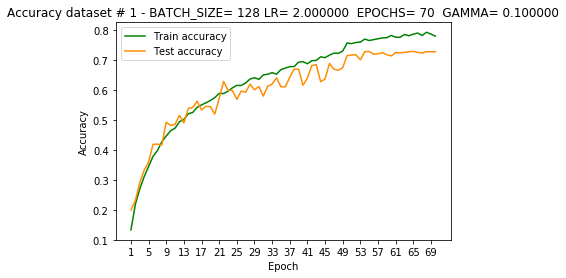

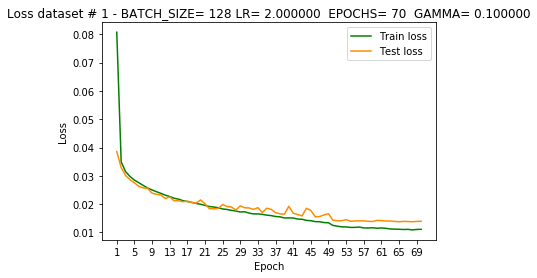

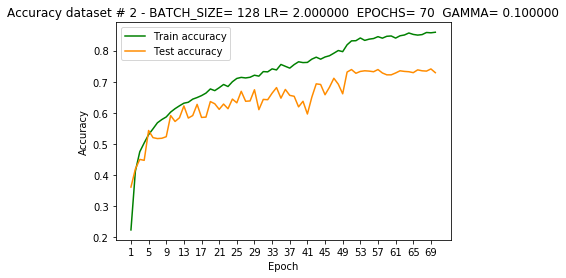

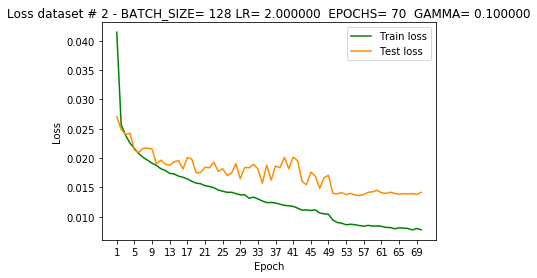

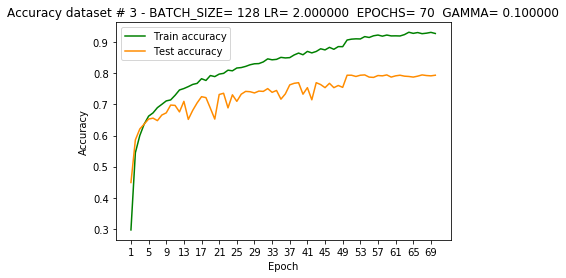

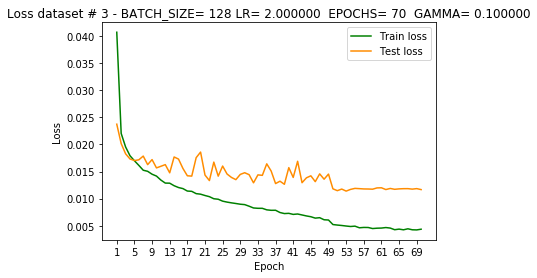

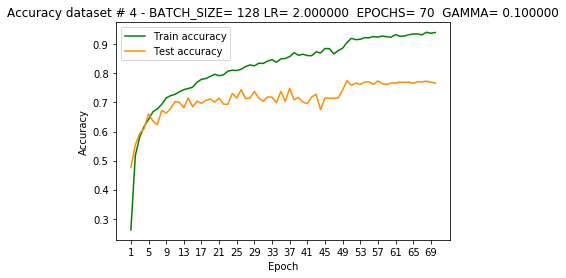

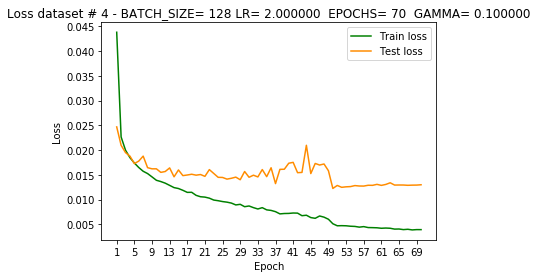

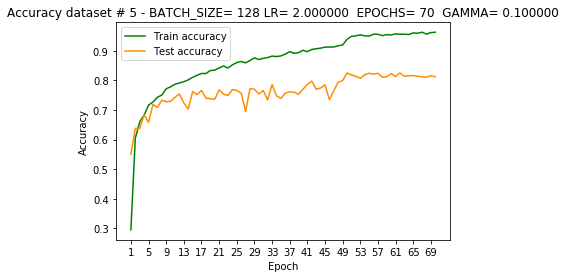

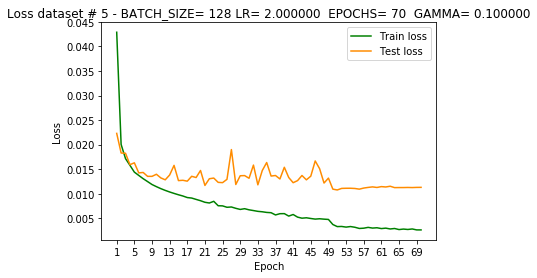

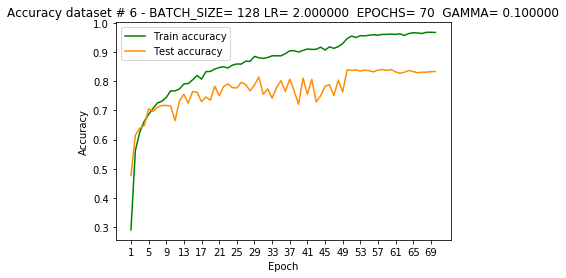

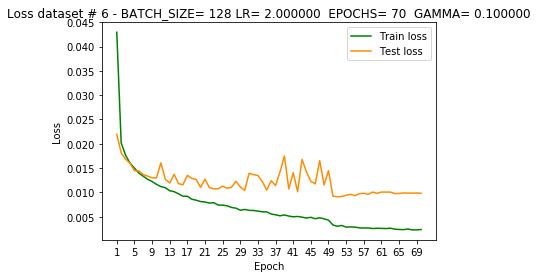

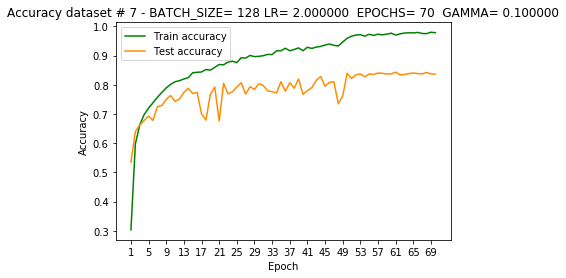

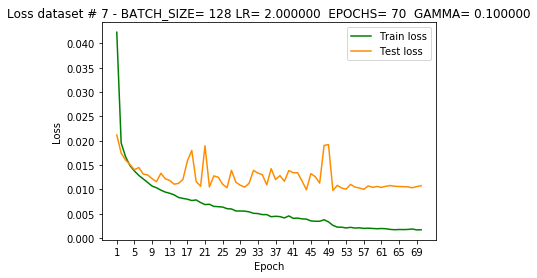

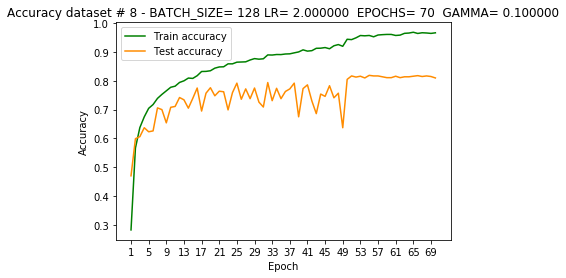

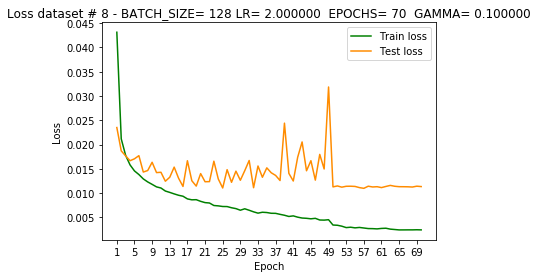

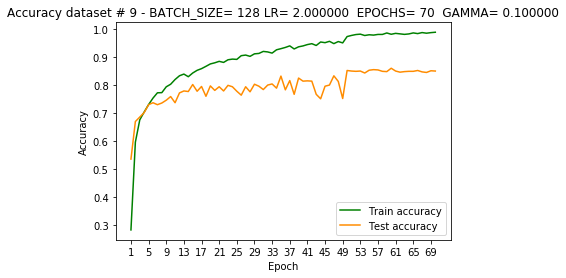

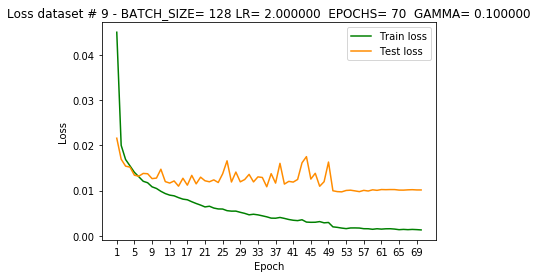

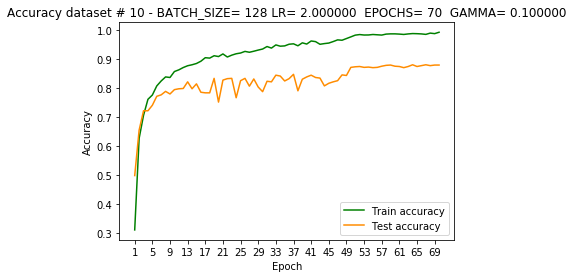

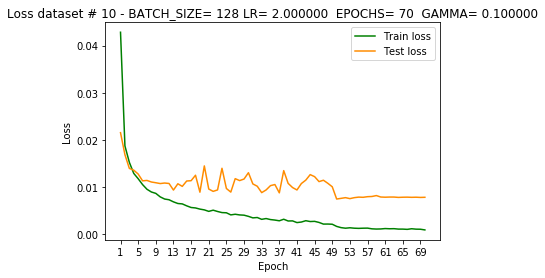

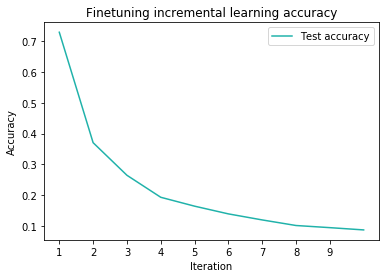

Accuracy last test [0.498, 0.655, 0.722, 0.722, 0.741, 0.772, 0.777, 0.789, 0.78, 0.795, 0.798, 0.799, 0.822, 0.798, 0.815, 0.786, 0.784, 0.784, 0.834, 0.752, 0.828, 0.833, 0.834, 0.767, 0.826, 0.834, 0.807, 0.832, 0.804, 0.788, 0.824, 0.822, 0.845, 0.842, 0.825, 0.833, 0.848, 0.791, 0.831, 0.839, 0.845, 0.837, 0.835, 0.808, 0.817, 0.822, 0.826, 0.846, 0.844, 0.872, 0.874, 0.875, 0.872, 0.873, 0.871, 0.872, 0.876, 0.879, 0.88, 0.876, 0.875, 0.871, 0.875, 0.881, 0.875, 0.878, 0.881, 0.878, 0.88, 0.88]


In [35]:
plot_ft(new_acc_train_list, new_acc_test_list, new_loss_train_list, new_loss_test_list, all_acc_list, parameters)
